# How Have Marriages Changed Over the Years?

Our client is a dating coach, and she the same question about her country's marriage trends and wished to gain more insight how it could impact her clients.

For our clients we will explore how the following
1. The Crude Marriage Rate (CRM) A look at a population's general inclinations toward getting married
2. The average age of the bride and groom at first marriage to how late or early in adulthood people are marrying
3. And the age group of first marriage, for a detailed look at what ages are the most common for men and women, and if there is a trend in delaying marriage. 

Analyzing these trends will reveal the people's expectation and preferences when it comes to planning out their relationships.

# What Data Do We Have At out Disposal?
Our our explorations we have pulled data from two sources: 
1. [Eurostat](https://ec.europa.eu/eurostat/web/main/home) - Provides and harmonizes statistics across member states of the European Union
2. [BDL](https://bdl.stat.gov.pl/bdl/start) - The Local Data Bank (BDL). Poland's largest database for national metrics

From BDL
- *Marriages Contracted by Age of Newlyweds* - Provides the age grouping of men and women at time of marriage
- *Marriages Contracted by Year* - The year and total marriages
- *Poland Population* - Total Population of the country from 2005

From Eurostat
- *Eu CMR* - Provides the European Union's crude marriage rate
- *Marriage by Singular Age* - Provides the total number of marriages for each age of both groom and bride for each year
 

## Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

plt.style.use('./assets/executive_report.mplstyle')

In [2]:
df_female = pd.read_csv('data/bride age group.csv', sep=';')
df_male = pd.read_csv('data/groom age group.csv', sep=';')
df_total_marriages = pd.read_csv('data/marriages_contracted_per_year.csv', sep=';')
df_pop = pd.read_csv('data/poland_population_2005.csv', sep=';') 
df_eu_cmr = pd.read_csv('data/tps00206 EU CMR 2001.csv')
df_sing_age = pd.read_csv('data/poland_marriages_by_age_gender_year.csv')


# Data Wrangling

### Marriages by Age Group

For the marriage data by age groups, we will concatenate the datasets for male and female and drop unnecessary columns.

In [3]:
# Denoting sex for each
df_female['sex'] = 'female'
df_male['sex'] = 'male'

# Dropping the rows representing total marriages regardless of age group 
df_female = df_female[df_female['Age of females'] != 'females total']
df_male = df_male[df_male['Age of males'] != 'males total']

# Dropping counterpart age of female and age of male columns
df_female.drop(columns='Age of males', inplace=True)
df_male.drop(columns='Age of females', inplace=True)

# Rename to age group
df_female.rename(columns={'Age of females' : 'age group'}, inplace=True)
df_male.rename(columns={'Age of males' : 'age group'}, inplace=True)

# Concatenating and renaming the columns
df_marriage = pd.concat([df_male, df_female], axis=0)
df_marriage.drop(
    columns=['Code','Name', 'Location', 'Types of marriages', 'Measure Unit', 'Attribute', 'Unnamed: 10'],
    inplace=True)

del(df_female, df_male)
df_marriage.head(5)

,age group,Year,Value,sex
14,under 20 years,2010,1320,male
15,under 20 years,2011,1090,male
16,under 20 years,2012,911,male
17,under 20 years,2013,716,male
18,under 20 years,2014,619,male


Our client specified that she had a focus on people dating in their early adulthood to late 30's, so we will group all ages past 40 into a single age group. 

In [4]:
new_age_dict = {
    'under 20 years' : '<20',
    '40-49' : '+40',
    '50-59' : '+40',
    '60 and more' : '+40'
}

df_marriage['age group'].replace(new_age_dict, inplace= True)
df_marriage = df_marriage.groupby(['Year', 'sex', 'age group'])['Value'].sum().reset_index()
df_marriage.head(6)

,Year,sex,age group,Value
0,2010,female,+40,13816
1,2010,female,20-24,79746
2,2010,female,25-29,89646
3,2010,female,30-34,26972
4,2010,female,35-39,9150
5,2010,female,<20,9007


To aid in our Analysis, we will compute the percentage of the total of marriages that each age group contributes and the age groups rank.

In [5]:
df_marriage['% of total'] = df_marriage['Value'] / df_marriage.groupby(['Year','sex'])['Value'].transform('sum')
df_marriage['rank'] = df_marriage.groupby(['Year','sex'])['Value'].rank(ascending=False)
df_marriage.head(6)


,Year,sex,age group,Value,% of total,rank
0,2010,female,+40,13816,0.060507,4.0
1,2010,female,20-24,79746,0.349247,2.0
2,2010,female,25-29,89646,0.392604,1.0
3,2010,female,30-34,26972,0.118124,3.0
4,2010,female,35-39,9150,0.040072,5.0
5,2010,female,<20,9007,0.039446,6.0


### Total Marriages by Year

Handling of this data is straightforward. We will extract the 'Year' and 'Value' columns for our analysis.

In [6]:
df_total_marriages = df_total_marriages.loc[:, ['Year','Value']]
df_total_marriages.head(5)

,Year,Value
0,1995,207081
1,1996,203641
2,1997,204850
3,1998,209430
4,1999,219398


### Total Population

We will process total population data in a similar fashion. We will extract the 'Year' and 'Value' columns while dropping any row with missing data.

In [7]:
df_pop = df_pop[['Year', 'Value']].dropna(axis=0, how='any')
df_pop.head(5)

,Year,Value
0,2005,38157055.0
1,2006,38125479.0
2,2007,38115641.0
3,2008,38135876.0
4,2009,38167329.0


### Poland's Crude Marriage Rate


To calculate the crude marriage rate of Poland, we simply divide the number of marriages buy the total population across each year and multiply by 1,000 to get the number of marriages per 1,000 people.

In [8]:
df_cmr = pd.merge(df_total_marriages, df_pop, on='Year', how='outer')
df_cmr = df_cmr.dropna().reset_index(drop=True)

df_cmr.columns = ['year', 'marriages', 'population']
df_cmr['cmr'] = (df_cmr['marriages'] / df_cmr['population'] * 1000).round(1)
df_cmr.drop(columns=['marriages', 'population'], inplace=True)

df_cmr.tail(10)

,year,cmr
9,2014,4.9
10,2015,4.9
11,2016,5.0
12,2017,5.0
13,2018,5.0
14,2019,4.8
15,2020,3.8
16,2021,4.4
17,2022,4.1
18,2023,3.9


### EU's Crude Marriage Rate

Cleaning this dataset only required that we extract the Year, the CMR column and filter for the European Union as a whole. This will aid in comparing the trend in Poland to the EU. 

In [9]:
df_eu_cmr = df_eu_cmr[df_eu_cmr['geo'] == 'EU27_2020']
df_eu_cmr = df_eu_cmr.loc[:, ['TIME_PERIOD', 'OBS_VALUE']]
df_eu_cmr.columns = ['year', 'cmr eu']
df_eu_cmr.head(10)

,year,cmr eu
0,2001,4.9
1,2002,4.9
2,2003,4.8
3,2004,4.8
4,2005,4.8
5,2006,4.8
6,2007,5.0
7,2008,4.8
8,2009,4.6
9,2010,4.4


We will merge the cmr rate we calculated for poland, with the EU cmr data.

In [10]:
df_cmr = pd.merge(df_cmr, df_eu_cmr, on='year', how='outer')
df_cmr = df_cmr.sort_values('year').reset_index(drop=True)
del(df_eu_cmr)
df_cmr.tail(10)

,year,cmr,cmr eu
13,2014,4.9,4.2
14,2015,4.9,4.3
15,2016,5.0,4.4
16,2017,5.0,4.4
17,2018,5.0,4.5
18,2019,4.8,4.3
19,2020,3.8,3.2
20,2021,4.4,3.9
21,2022,4.1,4.2
22,2023,3.9,NaN


### Ave Age of First Marriage

To get an accurate value for the average age at time of marriage, we will compute the weighted average using the number of marriages contracted for each age. Other datasets have this information already formatted, but start at 2011 only. Using this method we can get the same metric starting from 1995.

In [11]:
df_sing_age.head(5)

,DATAFLOW,LAST UPDATE,freq,unit,sex,age,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1995,0,NaN
1,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1996,0,NaN
2,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1997,0,NaN
3,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1998,0,NaN
4,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1999,0,NaN


The data set will be grouped by Year and Sex, and then we will apply a function to calculate the weighted average age.

In [12]:
# Correcting 'age' to be an integer
df_sing_age['age'] = df_sing_age['age'].str.lstrip('Y').astype(int)

# Calculating the weighted average
df_avg_age = df_sing_age.groupby(['TIME_PERIOD', 'sex']).apply(
    lambda x: (x['age'] * x['OBS_VALUE']).sum() / x['OBS_VALUE'].sum()
).round(1).reset_index(name='ave age')

# Formatting columns and values
df_avg_age.columns = ['year', 'sex', 'ave age']
df_avg_age.replace(to_replace={'F': 'female', 'M':'male'}, inplace=True)

df_avg_age.tail(10)

,year,sex,ave age
46,2018,female,27.5
47,2018,male,29.7
48,2019,female,27.8
49,2019,male,30.0
50,2020,female,28.0
51,2020,male,30.2
52,2021,female,28.2
53,2021,male,30.4
54,2022,female,28.6
55,2022,male,30.8


In [13]:
## Exporting Dataframes for Dash app

if False:
    df_avg_age.to_csv(f'./data/dash_data/average_marriage_age.csv')
    df_cmr.to_csv(f'./data/dash_data/crude_marriage_rate.csv')
    df_marriage.to_csv(f'./data/dash_data/marriage_by_age_group.csv')
    # df_pop.to_csv(f'./data/dash_data/df_.csv')
    df_total_marriages.to_csv(f'./data/dash_data/total_marriages.csv')


# Visualizing the Data

## Crude Marriage Rates

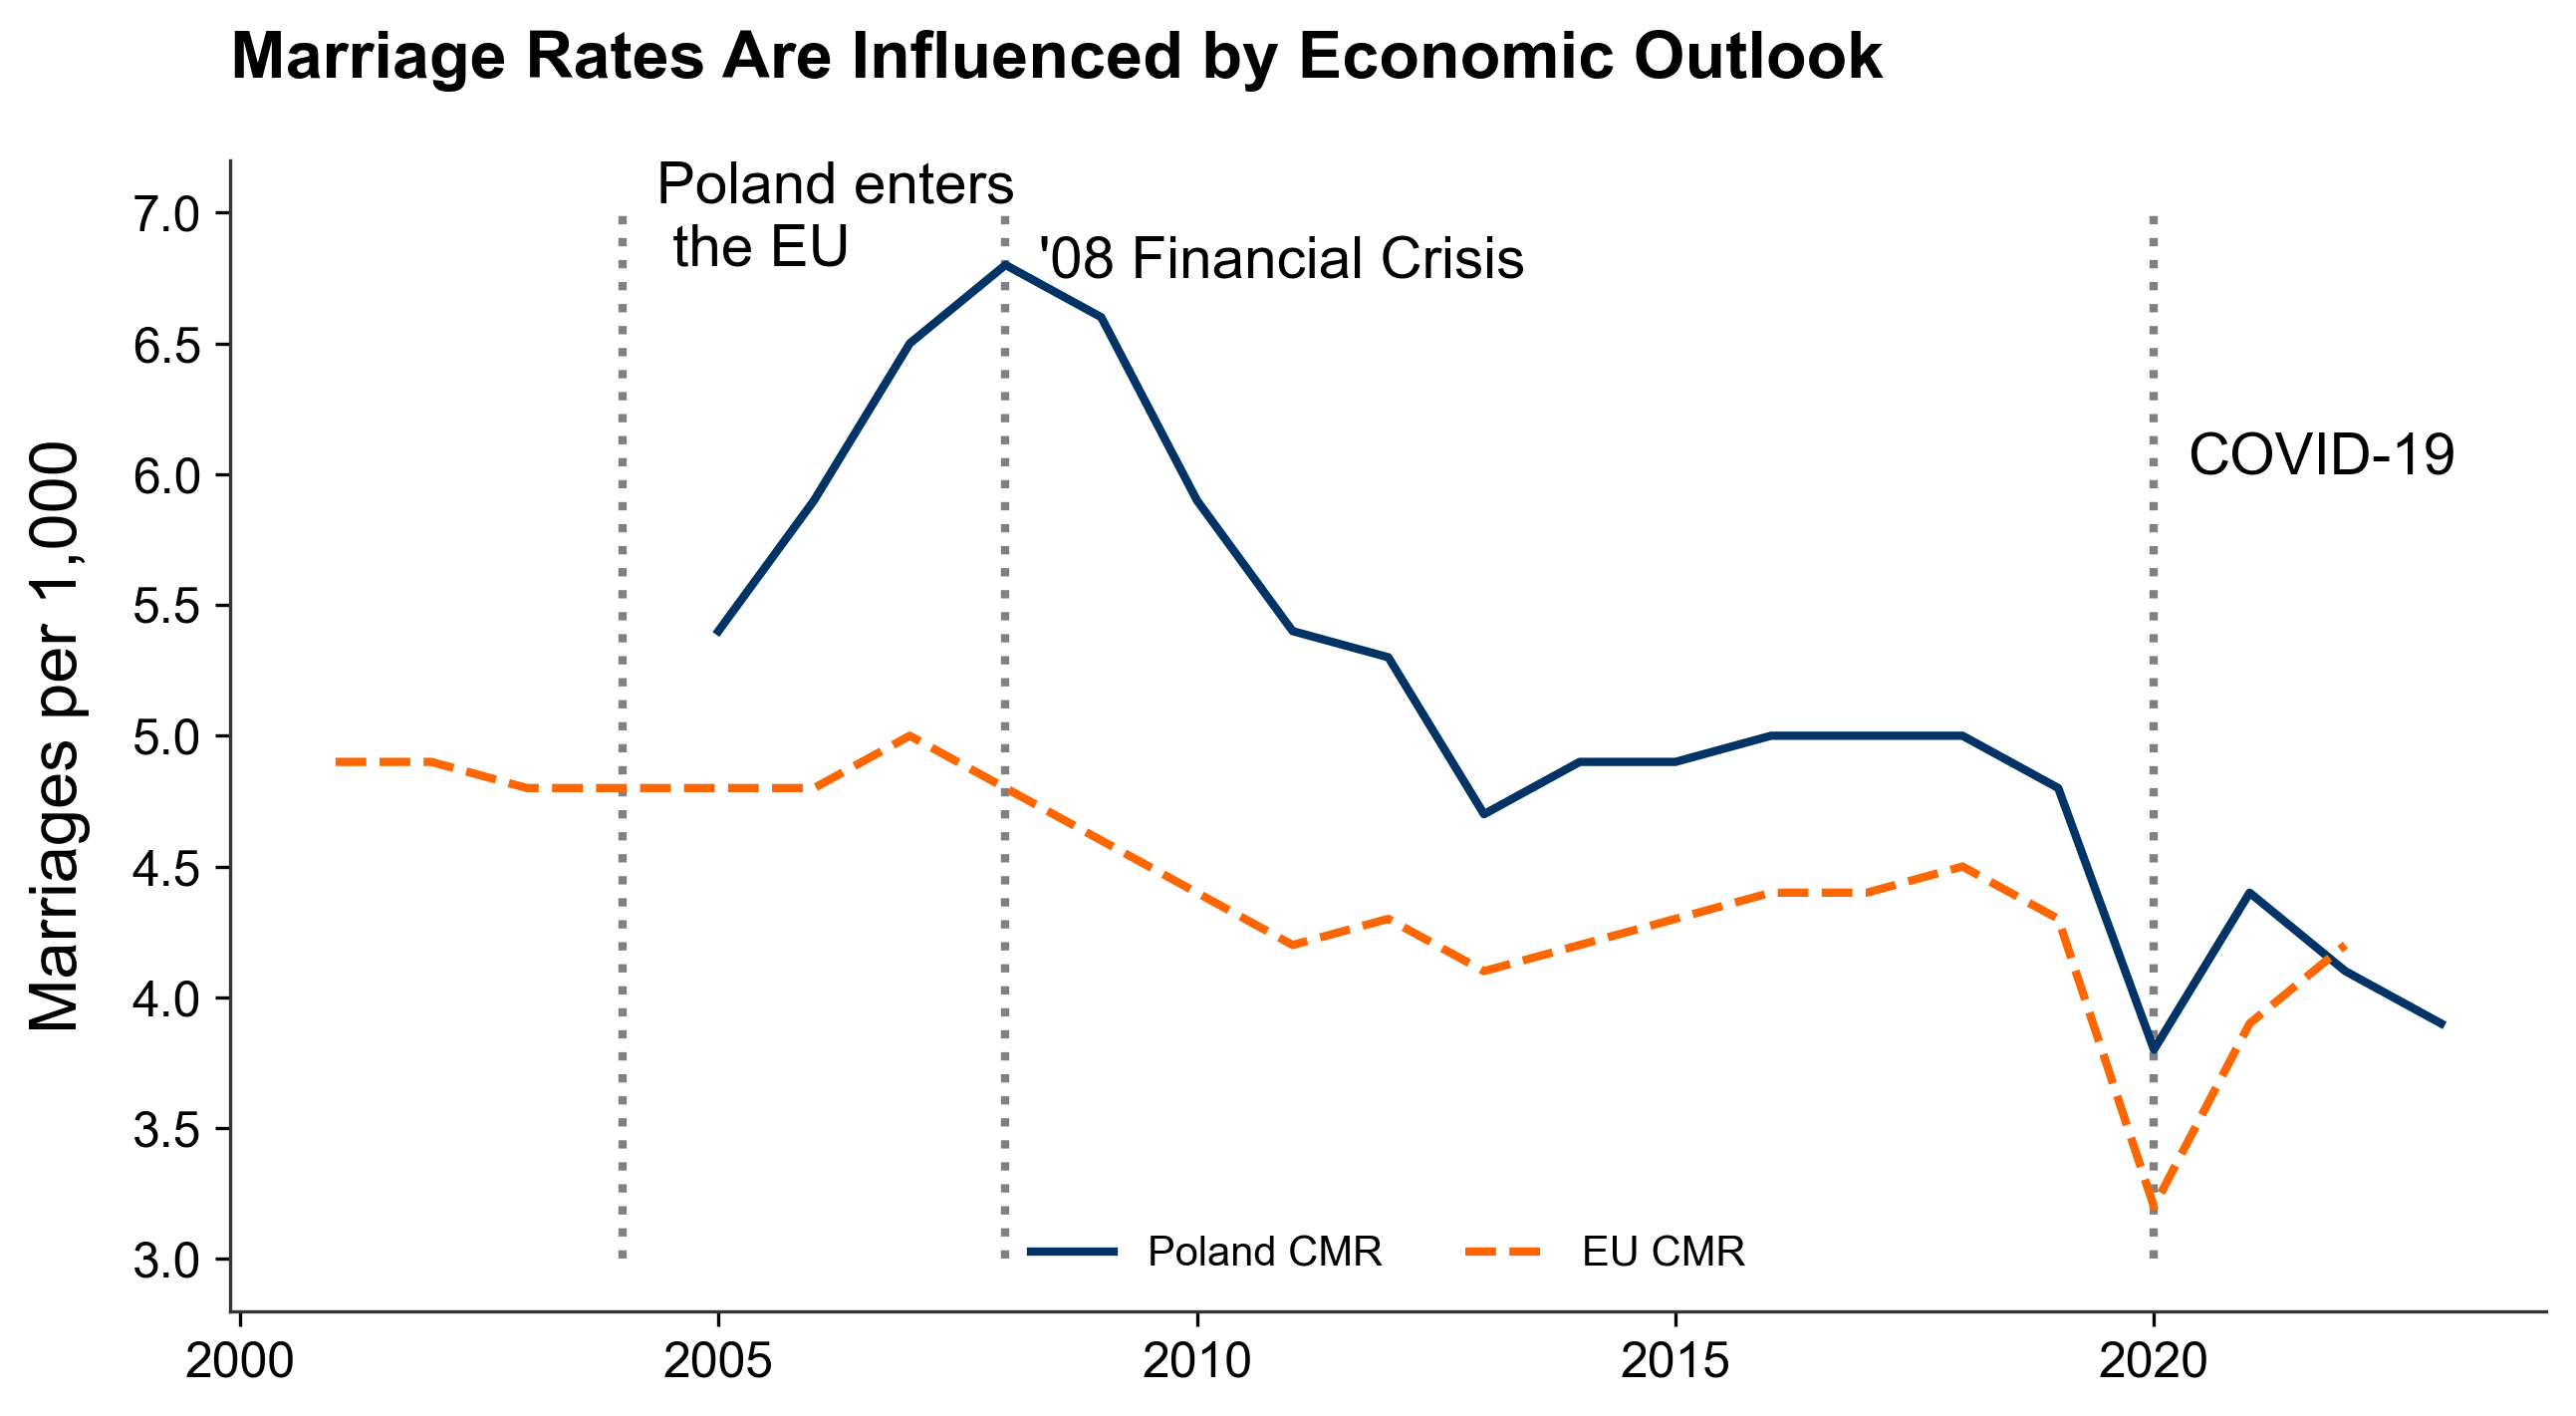

In [14]:
plt.figure(figsize=(10,5))

# ----- Axis Setup ----- #
ax1 = plt.gca()

# ----- Plots ----- #
sns.lineplot(df_cmr, x='year', y='cmr', label='Poland CMR', ax=ax1)
sns.lineplot(df_cmr, x ='year', y ='cmr eu', label= 'EU CMR', ax=ax1, linestyle='--')

# ----- Title Formatting ---- #
plt.title('Marriage Rates Are Influenced by Economic Outlook', loc='left', ha='left')
plt.xlabel('')

# ----- Axis Formatting ----- #
ax1.set_ylabel(ylabel='Marriages per 1,000')
ax1.grid(False)

# ----- Legend Formatting ----- #
lines_1, labels_1 = ax1.get_legend_handles_labels()

legend = plt.legend(title='', loc='lower center', ncol=len(df_avg_age['sex'].unique()))
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')

# ----- Vlines ---- #
events = [[2004,"Poland enters\n the EU", 6.80], [2008,'\'08 Financial Crisis', 6.75], [2020, 'COVID-19', 6.0]]

for event in events:
    plt.vlines(event[0], 3, 7, 'gray',':', label=event[1],zorder =0)
    plt.text(x = event[0]+.35, y = event[2], s= event[1])

plt.show()

Our chart shows that during times of positive or negative economic outlook, the marriage rates have grown or contracted accordingly. In 2004, Poland was admitted to the European Union with a positive expectation about the benefits it would bring to the national economy. We can see a sharp increase in marriage rates until 2008.

After the 2008 Financial Crisis, the marriage rate has been steadily decreasing. Unsurprisingly, we see a sharp drop in 2020, right as the COVID-19 Pandemic it at its highest point.

Interestingly, Poland faired comparatively well in the 2008 recession, with positive GDP growth consistent from 2009 to 2011 <sup>[1](https://tradingeconomics.com/poland/full-year-gdp-growth)</sup>. This is contrasted with the period from 2014 to 2019 GDP where growth was consistently above 3%, and crude marriage rate averaged held steady at 5.0.

 We can infer two things, positive economic periods may be overshadowed by an individual's perception of economic security not to mention changes in society's attitude towards the importance of marriage.

### Average Age of Marriage

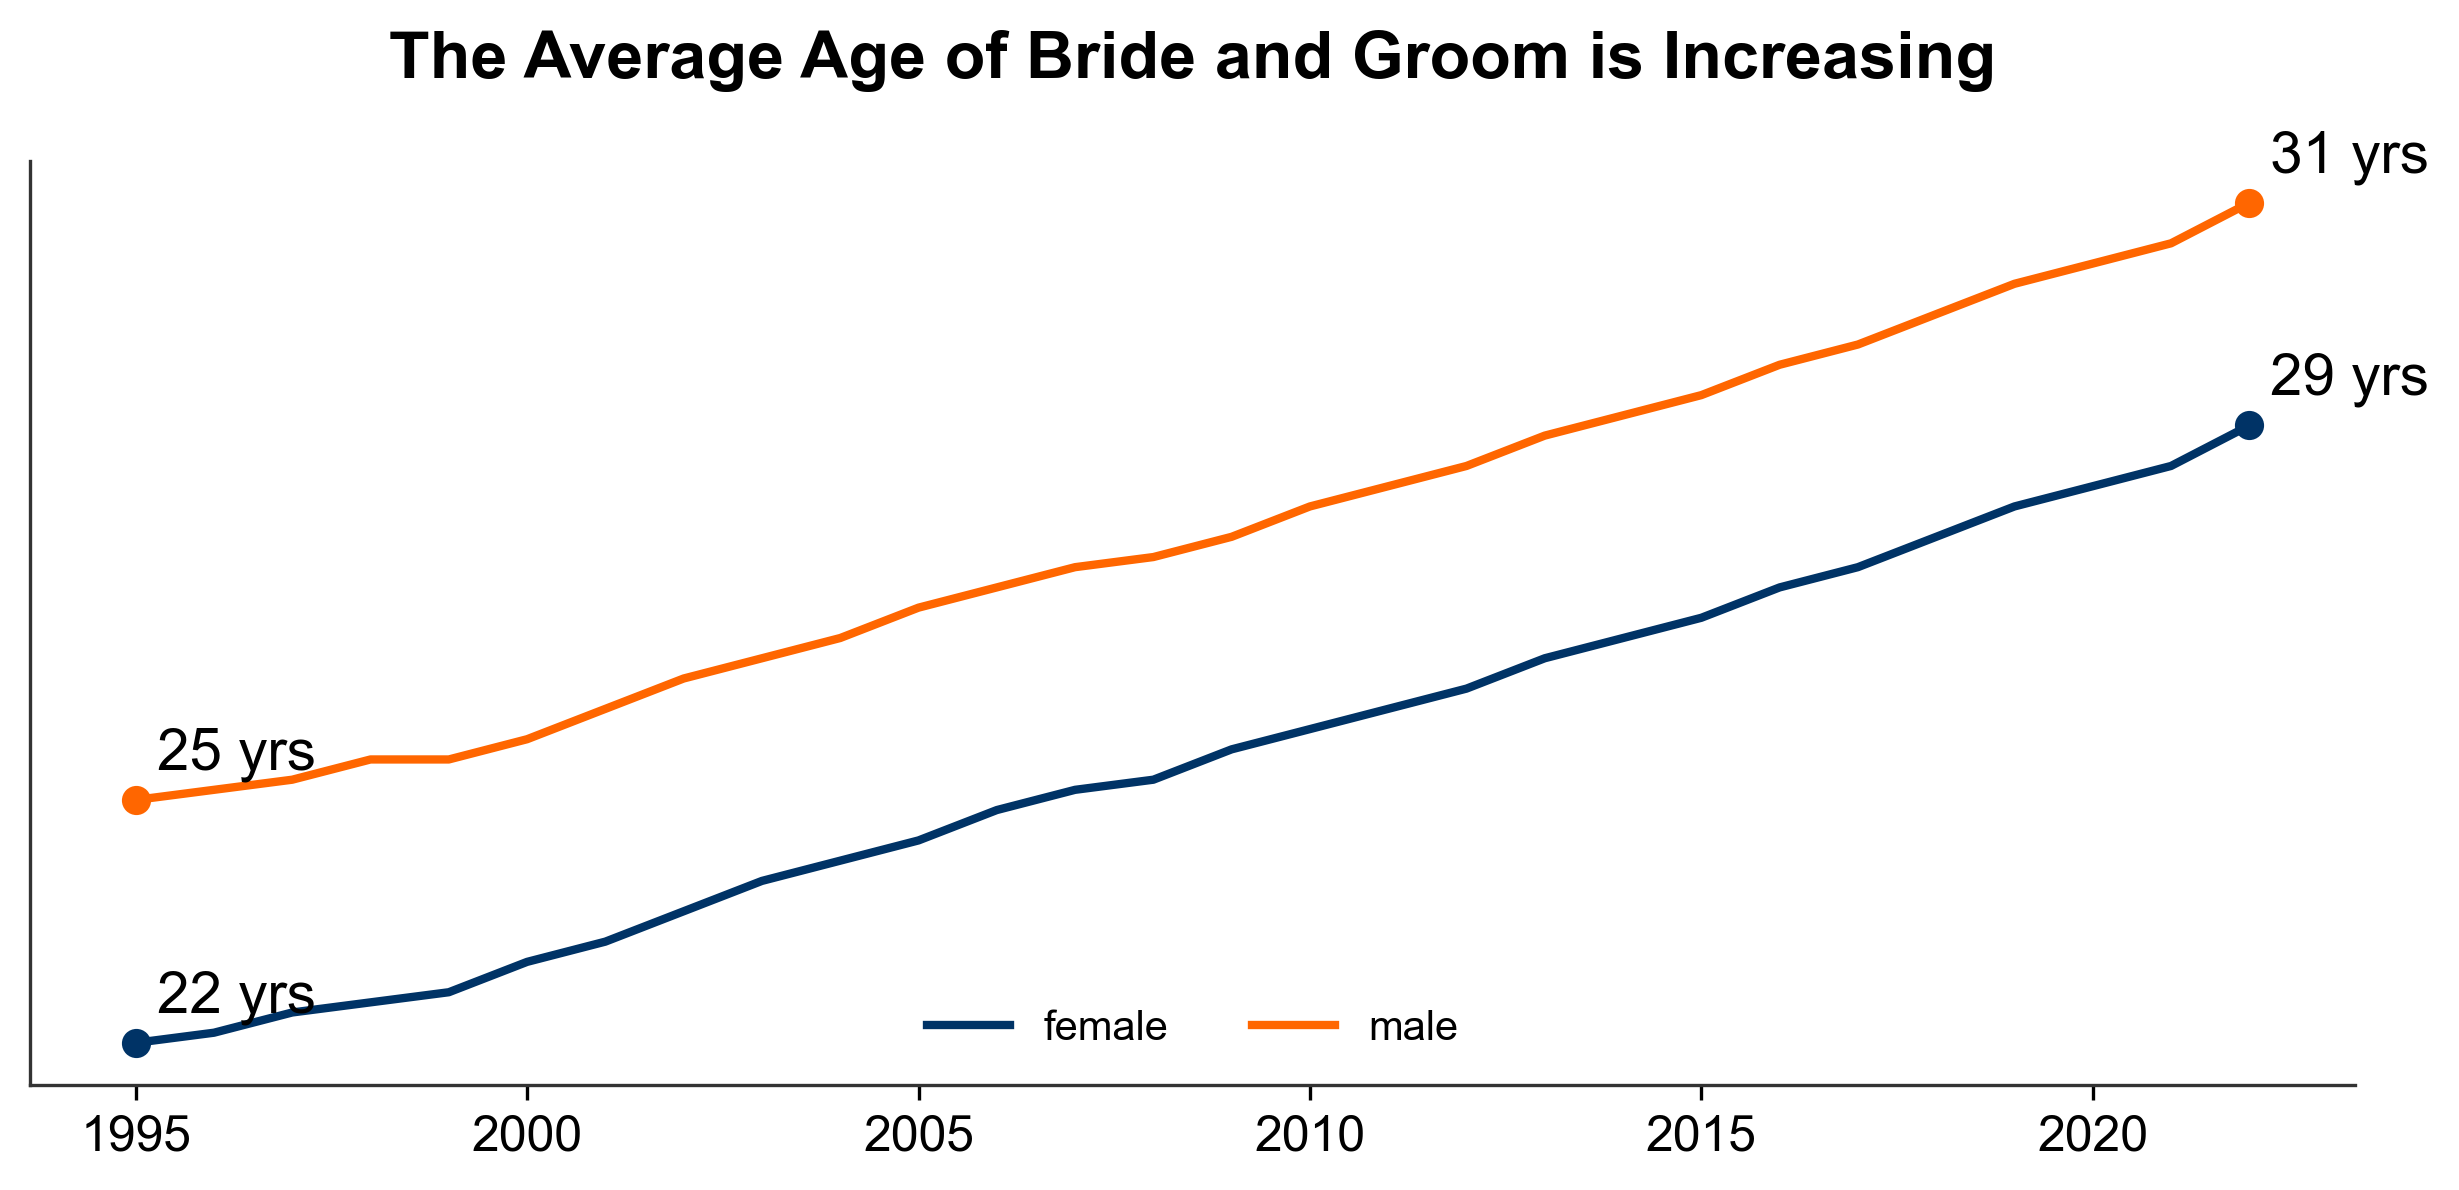

In [15]:
plt.figure(figsize=(10,4))

for sex in df_avg_age['sex'].unique():
    subset = df_avg_age[df_avg_age['sex'] == sex]
    plt.plot(subset['year'], subset['ave age'], label=sex)
    axis = plt.gca()
    axis.yaxis.set_visible(False)

    first_row = subset.iloc[[0]]  # Get the first row
    last_row = subset.iloc[[-1]]  # Get the last row
    # Combine them into a single DataFrame
    df_first_last = pd.concat([first_row, last_row])
    plt.scatter(df_first_last['year'], df_first_last['ave age'])

    for _, row in df_first_last.iterrows():
        text = plt.annotate(f"{row['ave age']:.0f}" + ' yrs',
                        xy = (row['year'], row['ave age']),
                        xytext =(5,11),
                        textcoords ='offset points',
                        ha='left', 
                        va='center',
                        fontsize =14
                        )
        
plt.yticks([])
plt.gca().yaxis.set_visible(False)
# plt.gca().spines['left'].set_visible(False)

# Legend
legend = plt.legend(title='', loc='lower center', ncol=len(df_avg_age['sex'].unique()))
legend.get_frame().set_facecolor('none') 
legend.get_frame().set_edgecolor('none') 

# Labels
plt.xlabel('')
plt.ylabel('Average Age')
plt.title('The Average Age of Bride and Groom is Increasing')

plt.show()

A key indicator of societal attitude towards marriage is the average age at which people marry. In many Western and developed nations there has been a trend of postponing marriage to later stages of life. Many factors contribute to this, including teh desire for financial security, a reduce emphasis on marriage overall, and a perceived high cost of starting a family. 

Poland seemingly is following a similar trend, as the average age of marriage for men and women has steadily increased over the years. On average Men are marrying six years later in life and women getting married seven years later than in previous decades.

We will examine marriages by the specific age groups, to get a deeper insight of how perception or at least the desire to marry have changed over time.

## Marriages By Age Groups

In [16]:
custom_palette = {
    '<20': 'red',
    '20-24': '#e60049',
    '25-29': '#9b19f5',
    '30-34': "#0bb4ff",
    '35-39': "#ffa300",
    '+40': 'grey'
}

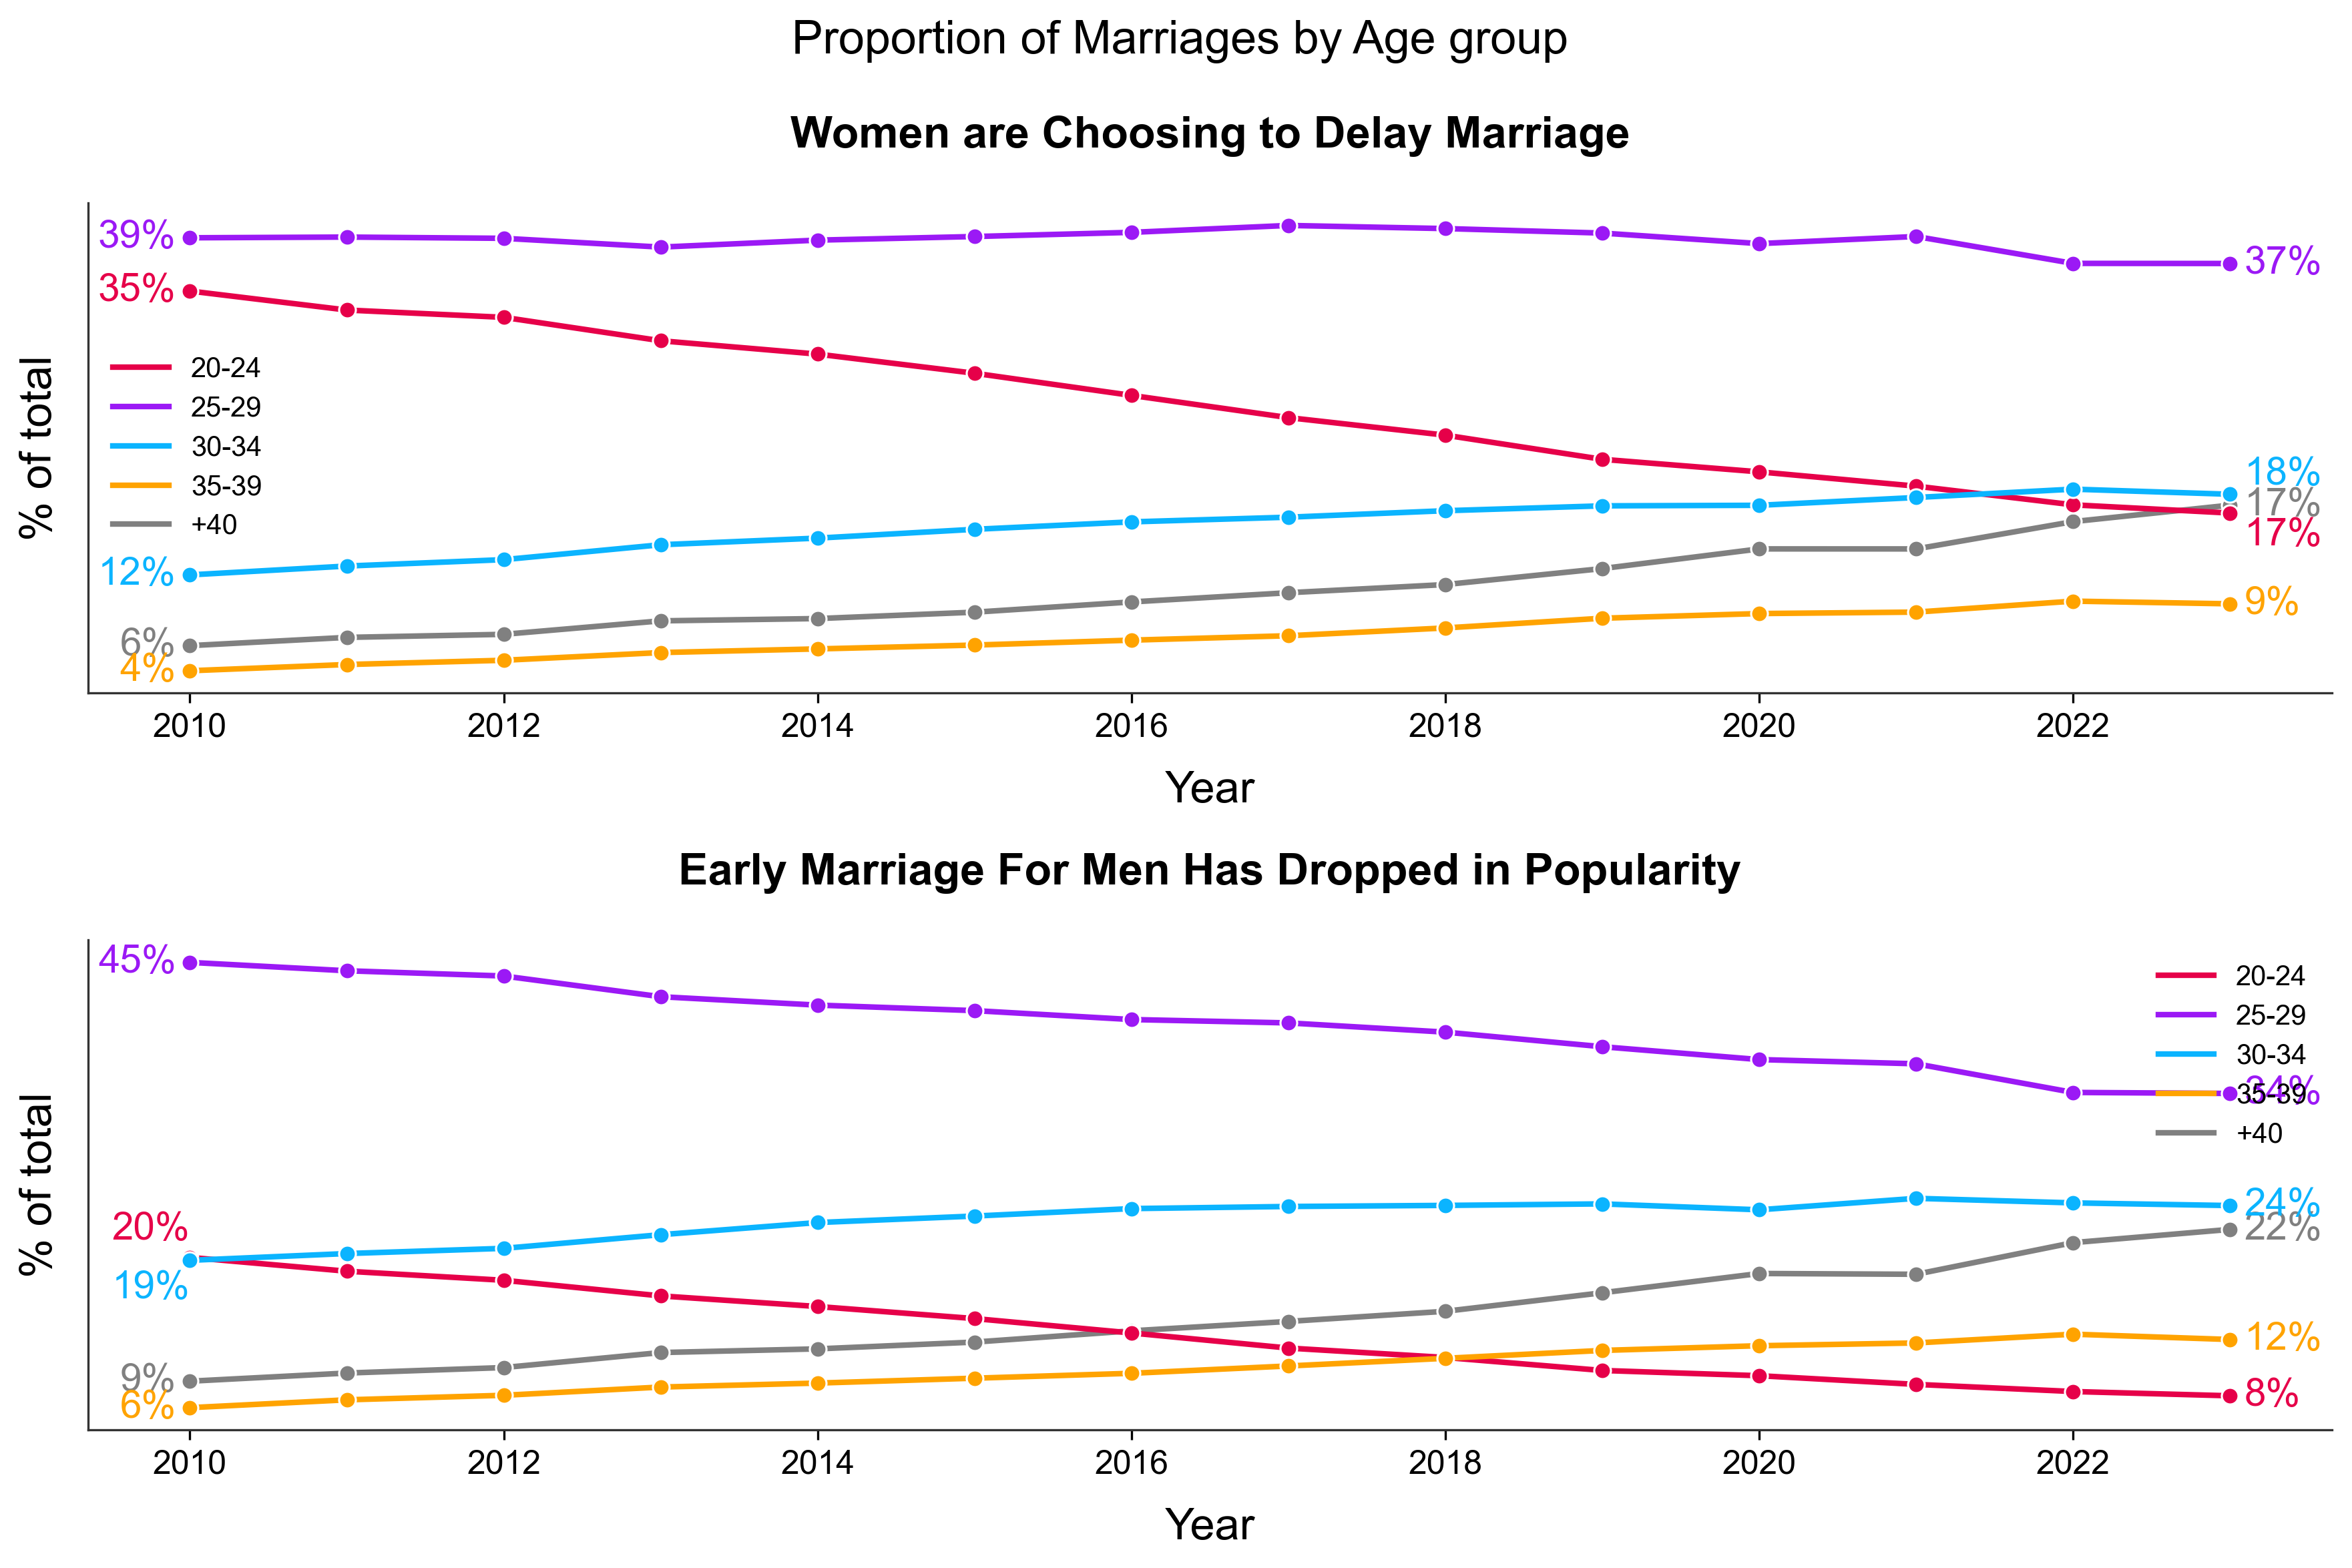

In [17]:
import matplotlib.ticker as mtick
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle('Proportion of Marriages by Age group')

for i, sex in enumerate(df_marriage['sex'].unique()):
    df_temp = df_marriage[(df_marriage['sex'] == sex) & (df_marriage['age group'] != '<20')]

    sns.lineplot(df_temp, x='Year', y='% of total', ax=axes[i], hue='age group', marker='o', palette=custom_palette)

    handles, labels = axes[i].get_legend_handles_labels()
    
    order = [1,2,3,4,0] 
    axes[i].legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    axes[i].set_title(f'{"Women are Choosing to Delay Marriage" if sex == "female" else "Early Marriage For Men Has Dropped in Popularity"}')
    axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))  # Assuming 'Value' is in the range [0, 1]
    
    for age_group in df_temp['age group'].unique():

        df_group = df_temp[df_temp['age group'] == age_group]
        last_row = df_group.iloc[-1]
        first_row = df_group.iloc[0]

        xy_pos_last = (5,0)
        xy_pos_first = (-5, 0)

        # Manually adjusting the position of annotations
        if sex == 'female':
            if age_group == '20-24':
                xy_pos_last = (5,-8)
            elif age_group == '30-34':
                xy_pos_last = (5,7)

        if sex == 'male':
            if age_group == '20-24':
                xy_pos_first = (0, 10)
            elif age_group == '30-34':
                xy_pos_first = (0, -10)

        last_text = axes[i].annotate("{:.0%}".format(last_row['% of total']),
                         xy = (last_row['Year'],last_row['% of total']),
                         xytext = xy_pos_last,
                         textcoords = 'offset points',
                         ha = 'left', 
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])
        
        first_text = axes[i].annotate("{:.0%}".format(first_row['% of total']),
                         xy = (first_row['Year'], first_row['% of total']),
                         xytext = xy_pos_first,
                         textcoords = 'offset points',
                         ha = 'right', 
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])
        
for ax in axes:
    ax.set_yticks([]) 
    ax.yaxis.set_ticks_position('none')
plt.tight_layout()
plt.show()

#### Women
We can readily see the proportion of age group of 20-24 years old females has dropped quite significantly; by roughly 17 percentage points over the that last 14 years. This drop is not so surprising, considering trends that younger women continue to focus on higher education and career, and opting to start a family later in life. 

The age group of 25-29 on the other hand, still remains the popular age bracket for young women, seeing ver little shift 

#### Men
For men the trend is very similar. Marriages by men in early twenties has dropped by 12 percentage points and late twenties by almost the same at 11 percentage points. 

Often, financial stability and career development are the primary reason why men are waiting until their thirties to begin a family. Other sociological factors come into play as well, as for women, such as the change in attitudes toward traditional relationships.

## Issue with this approach
A challenge with using the relative percentage of total marriages by age group is that a change in one group's value changes all other. The groups are not independent variables; an increase in one group's proportions, necessitates in a decrease for the rest.

While this analysis is helpful at understanding the _proportion_ of marriages by age group in a given year, it does not accurately show the trend independent of other groups. 

One option is to plot the absolute number of marriages, though this approach, but it does not account for changes in population overall. For example an increase in marriages for age groups 25-29 may be misleading if  there was also a increase in the total population.

## CMR for Age Groups
To avoid these issues, we will use the crude  marriage rate (CMR) for each age group. This provides a more accurate comparison by normalizing the number of marriages against the total population, while avoiding the influence of changes in total population

In [18]:
df_grouped_cmr = pd.merge(df_marriage, df_pop, on='Year', how='left')
df_grouped_cmr = df_grouped_cmr.rename(columns={'Value_x':'total marriages', 'Value_y':'population'})
# We multiple by 10,000 instead of 1,000 so we have more readable values
df_grouped_cmr['group cmr'] = df_grouped_cmr['total marriages'] / df_grouped_cmr['population'] * 10_000


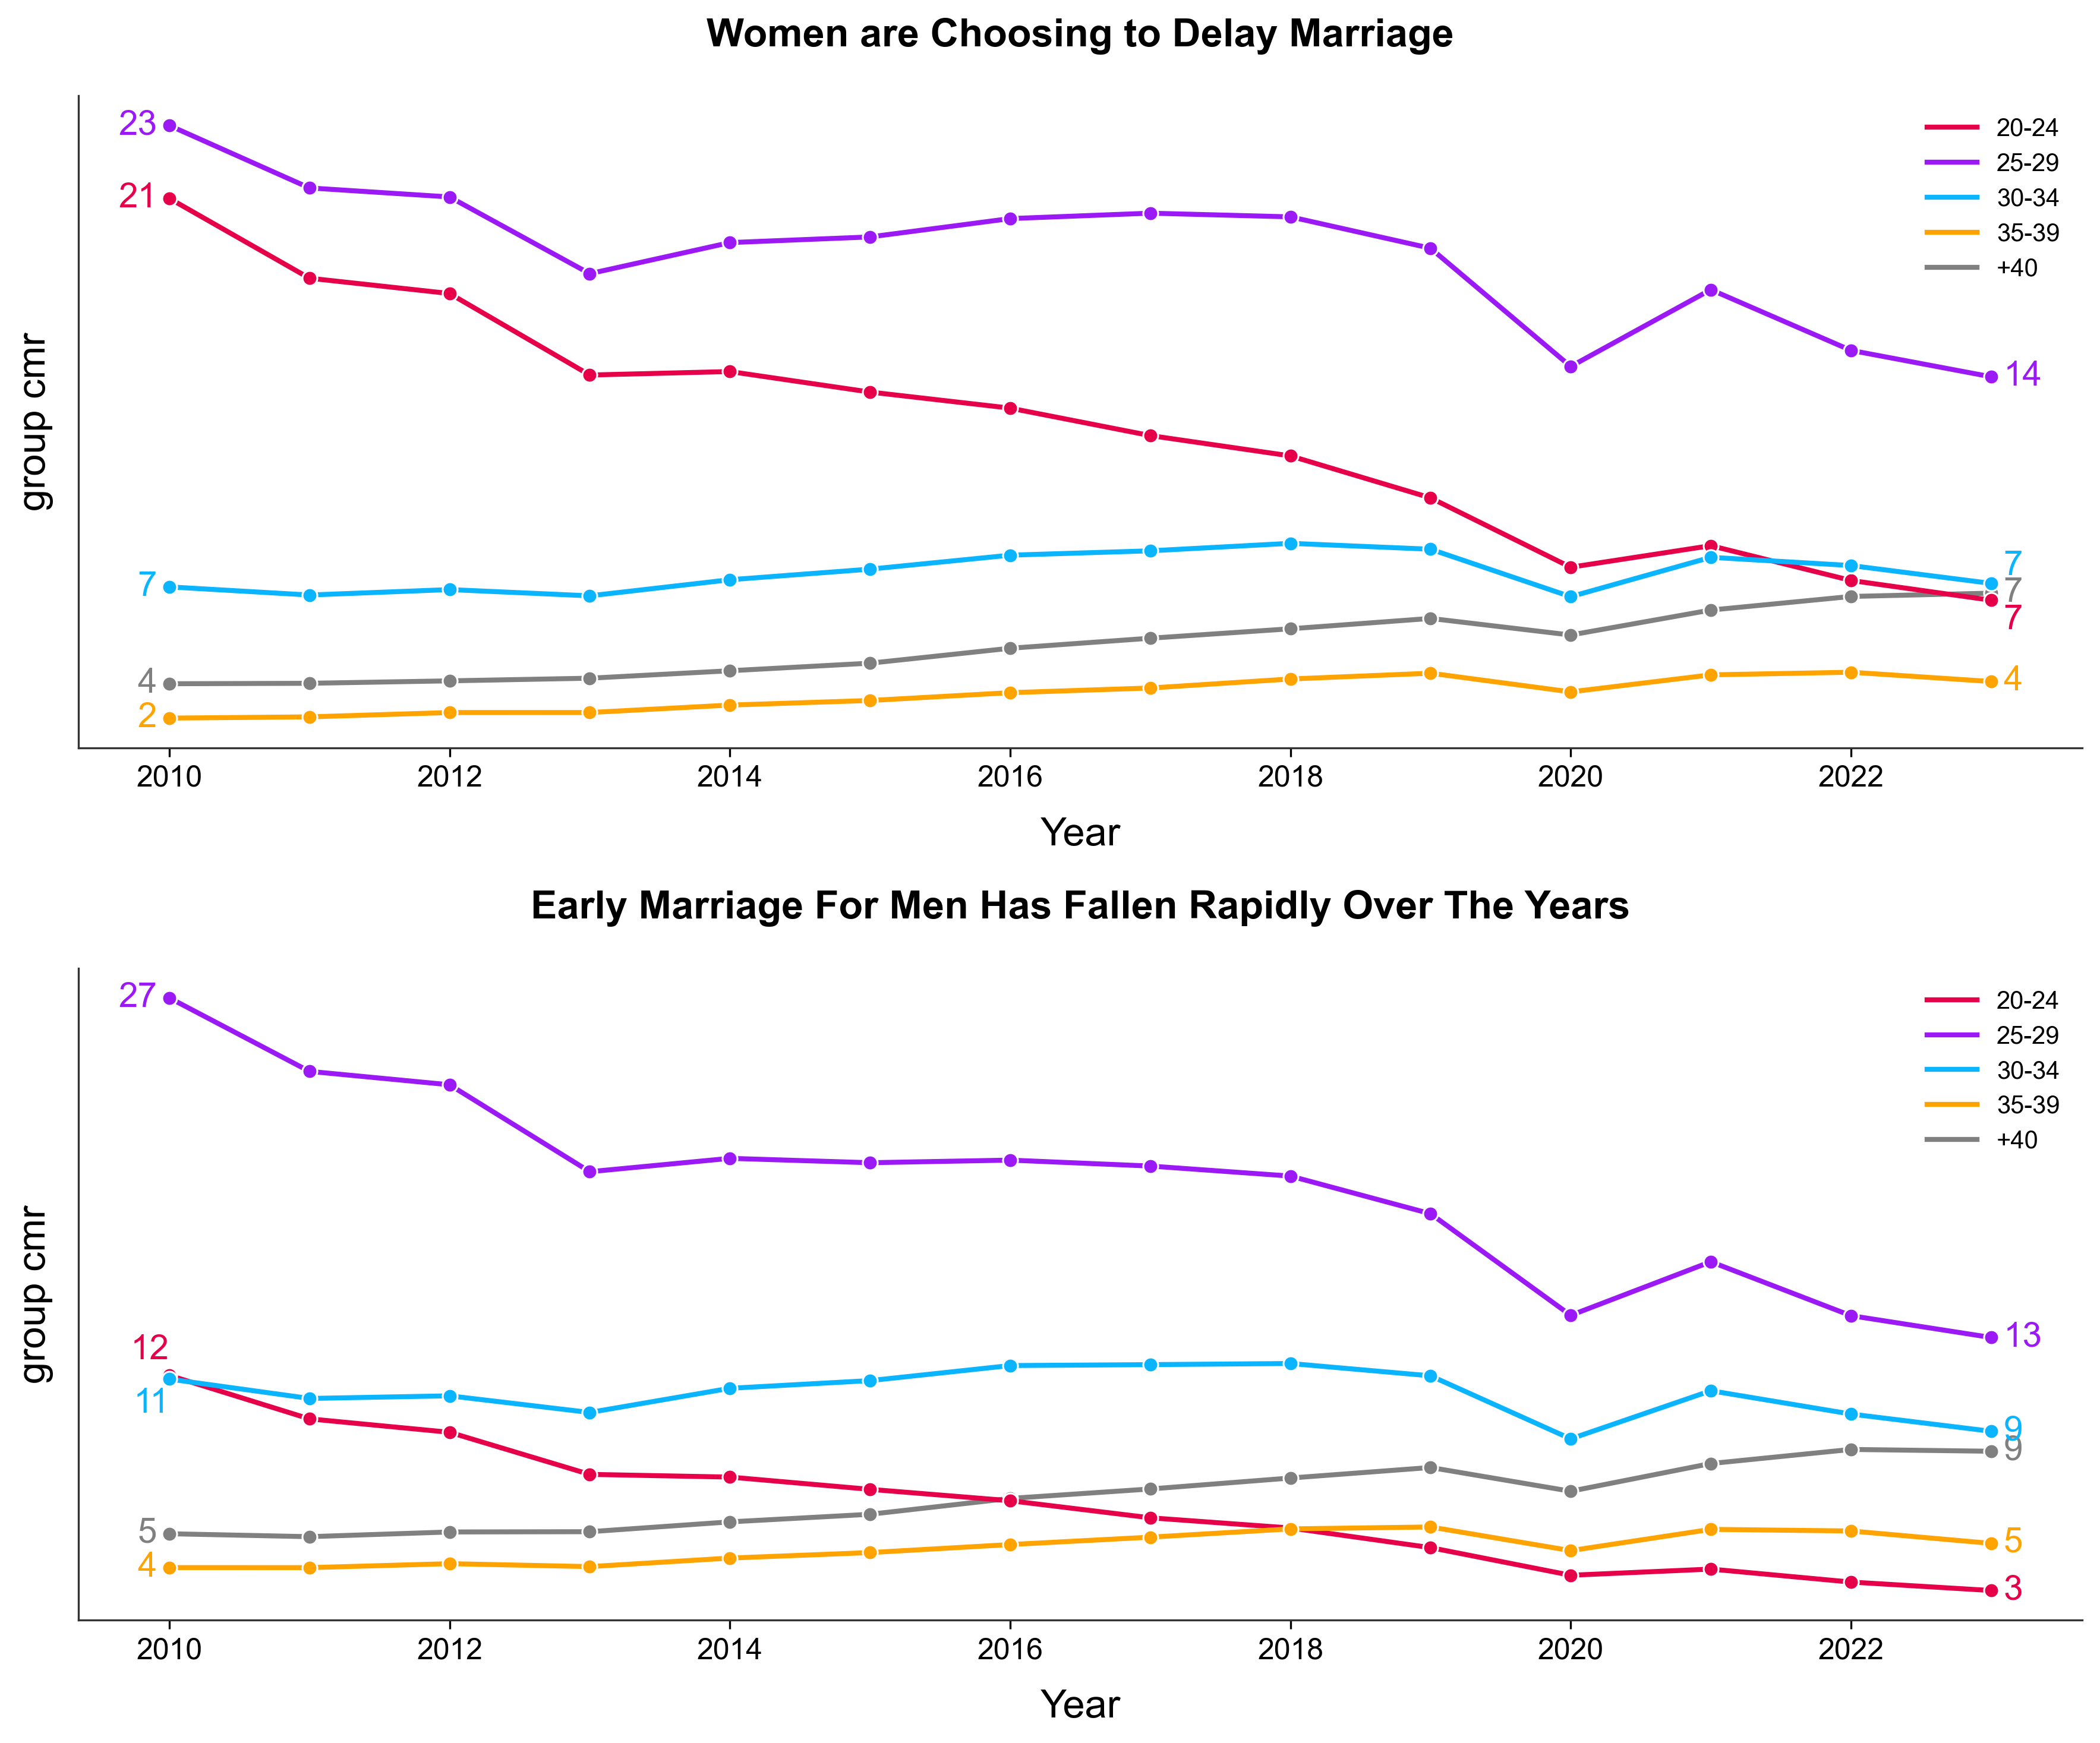

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
import matplotlib.ticker as mtick

for i, sex in enumerate(df_grouped_cmr['sex'].unique()):
    df_temp = df_grouped_cmr[(df_grouped_cmr['sex'] == sex) & (df_grouped_cmr['age group'] != '<20')]

    sns.lineplot(df_temp, x='Year', y='group cmr', ax=axes[i], hue='age group', marker='o', palette=custom_palette)

    handles, labels = axes[i].get_legend_handles_labels()
    
    order = [1,2,3,4,0] 
    axes[i].legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    axes[i].set_title(f'{"Women are Choosing to Delay Marriage" if sex == "female" else "Early Marriage For Men Has Fallen Rapidly Over The Years"}')
    axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))  # Assuming 'Value' is in the range [0, 1]
    
    for age_group in df_temp['age group'].unique():

        df_group = df_temp[df_temp['age group'] == age_group]
        last_row = df_group.iloc[-1]
        first_row = df_group.iloc[0]

        xy_pos_last = (5,0)
        xy_pos_first = (-5, 0)

        if sex == 'female':
            if age_group == '20-24':
                xy_pos_last = (5,-8)
            elif age_group == '30-34':
                xy_pos_last = (5,7)

        if sex == 'male':
            if age_group == '20-24':
                xy_pos_first = (0, 10)
            elif age_group == '30-34':
                xy_pos_first = (0, -10)

        last_text = axes[i].annotate("{:.0f}".format(last_row['group cmr']),
                         xy = (last_row['Year'],last_row['group cmr']),
                         xytext = xy_pos_last,
                         textcoords = 'offset points',
                         ha = 'left', 
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])
        
        first_text = axes[i].annotate("{:.0f}".format(first_row['group cmr']),
                         xy = (first_row['Year'], first_row['group cmr']),
                         xytext = xy_pos_first,
                         textcoords = 'offset points',
                         ha = 'right', 
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])
        
# Hide y-axis labels and spine if desired
for ax in axes:
    ax.set_yticks([])  # Remove tick marks
    ax.yaxis.set_ticks_position('none')  # Ensure no ticks are visible
plt.tight_layout()
plt.show()

# Analysis
## Women
For age groups 30-34 and 35-39, there has been relatively minor change in the number of marriages  compared to the changes in  20-24 and 25-29 age brackets. For women aged group 20-24 the number of marriages has dropped by 66% and has fallen by 60% for a those aged 25-29 (while still remaining the most popular age group for marriage). The sharp decline in marriages for women aged 20-29 aligns with the overall decreasing crude marriage rate for Poland. This indicates that the decline in marriages has been driven by younger women.

What stands out is that there is no significant increase in marriages for women aged 30-39. We can infer that there is likely a sociological factor at play. As seen elsewhere, there could be a cultural shift away from marriage in general, where the importance of marriage has decreased or are forgoing marriage altogether.


## Men
The trends for men closely mirror that of women. Marriages by men of ages 20-24 has fallen by 75% and has fallen by 50% for men aged 25-29. And as in the case with women, marriages in the early and late thirties has remained relatively constant.


# Findings
For our client, we provided the insight:
* The overall rate of marriage in Poland has been decreasing since 2008, and has begun to closely mirror the trends of Europe
* The decline in marriages is heavily influenced by a decline in the number of young men and women between ages 20-29 getting married
* The number of marriages by those in their 30's remained relatively stable
